imports

In [69]:
import os
#only print error messages from tensorflow
import tensorflow as tf
import numpy as np
import math
import time
import pickle
import bz2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler,MaxAbsScaler
import copy
from sklearn.metrics import mean_squared_error,mean_absolute_error
import scipy.optimize as opt
from itertools import chain

In [70]:
#https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m

In [500]:
def analytical_eq(xy,xo,yo,No,T):   
    x, y = xy
    
    Nex = 100000-No
    
    # out = (No/math.pi)*np.exp(-(x-xo)**2)*np.exp(-(y-yo)**2) + (Nex/(2*math.pi*T))*np.exp((-(x-xo)**2)/(2*T))*np.exp((-(y-yo)**2)/(2*T))
    out = (Nex/(2*math.pi*T))*np.exp((-(x-xo)**2)/(2*T))*np.exp((-(y-yo)**2)/(2*T))

    # out = (out - np.min(out)) / np.max(out)
    return out

In [490]:
num_atoms = 100000
length = 100
dimensions = 2
        
        
def generate_image(length,num_atoms,dimensions,temp):
    '''
    generate image using sampling
    '''

    x_list = []
    y_list = []
    
    trans_temp = (num_atoms/(2*1*1.645))**(1/dimensions)
    
    # temp = np.random.uniform(trans_temp//2,int(trans_temp*2))
    # temp = 300
    
    temp_ratio = temp/trans_temp

    num_BEC_atoms = 0
    if temp < trans_temp:
        num_BEC_atoms = num_atoms*(1-(temp/trans_temp)**dimensions)
        
    count = 0
    
    for i in range(num_atoms):
        probability = np.random.rand()
        if temp_ratio >1 :
            temp_ratio = 1
        BEC_probability = (1-(temp_ratio)**dimensions)
        if probability <= BEC_probability:
            count += 1
            x_list.append(np.random.normal(0,math.sqrt(1/2)))
            y_list.append(np.random.normal(0,math.sqrt(1/2)))

        else:
            x_list.append(np.random.normal(0,math.sqrt(temp)))
            y_list.append(np.random.normal(0,math.sqrt(temp)))



    hist = np.histogram2d(x_list,y_list,length)[0]
    hist = hist.tolist()
    return hist,temp,num_BEC_atoms,count

test_im_count = 10
test_ims = []
labs = []
temp = 300
for i in range(test_im_count):
    curr_im, t, n, count = generate_image(length,num_atoms,dimensions,temp)
    
    test_ims.append(np.asarray(curr_im))
    labs.append((t,n,count))

test_ims = np.stack(test_ims)
labs = np.stack(labs)

In [491]:
test_ims.shape

(10, 100, 100)

In [492]:
stdev_test_ims = np.std(test_ims,axis = 0)

In [493]:
std_err = stdev_test_ims / np.sqrt(test_ims.shape[0])

In [494]:
# std_err = (std_err - np.min(std_err)) / np.max(std_err)

In [495]:
mean_test_im = np.mean(test_ims,axis = 0)

In [496]:
# mean_test_im = (mean_test_im - np.min(mean_test_im)) / np.max(mean_test_im)

In [513]:
summ_all_mean = np.sum(mean_test_im)
summ_all_mean

99999.99999999999

In [523]:
pxy = mean_test_im/summ_all_mean
px = np.sum(pxy,axis = 1)
res = px * np.linspace(-49, 50, 100)
# stdev_mean_cols = np.std(summ_mean)
# stdev_mean_cols
expected_val_x = np.sum(res)
expected_val_x2 = np.sum(px * np.linspace(-49, 50, 100) ** 2)


In [524]:
np.sum(px)

1.0000000000000002

In [525]:
expected_val_x

1.4756310000000001

In [526]:
expected_val_x2

131.464557

In [506]:
x = np.linspace(-49, 50, 100)
y = np.linspace(-49, 50, 100)
x, y = np.meshgrid(x, y)

num_atoms = 100000
dimensions = 2
# temp = 300

trans_temp = (num_atoms/(2*1*1.645))**(1/dimensions)
# num_BEC_atoms = num_atoms*(1-(temp/trans_temp)**dimensions)
num_BEC_atoms = 0

actual = analytical_eq((x,y),0,0,num_BEC_atoms,temp)

In [512]:
summ = np.sum(actual,axis = 1)
stdev_cols = np.std(summ)
stdev_cols

794.6282601567918

In [516]:
np.sum(actual)

99221.05609856438

In [504]:
# length = 100
# actual = np.reshape(actual,(length,length))
# actual.shape

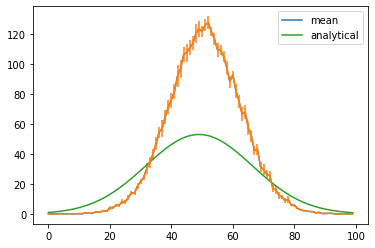

In [505]:
#mean gaussian

row = 50

plt.plot(np.arange(len(mean_test_im[0])),mean_test_im[row],label = "mean")
plt.errorbar(np.arange(len(mean_test_im[0])),mean_test_im[row],yerr = std_err[row])
plt.plot(np.arange(len(mean_test_im[0])),actual[row],label = "analytical")
plt.legend()

In [389]:
num_atoms = 100000
temp_ratio = (num_atoms/(2*1*1.645))**0.5
length = 100
dimensions = 2

x = np.linspace(-length//2+1, length//2, length)
y = np.linspace(-length//2+1, length//2, length)
x, y = np.meshgrid(x, y)

        
        
def generate_image_without_sampling(temp_ratio,length,num_atoms,dimensions,x,y):

    res = np.zeros((length,length))
    
    trans_temp = (num_atoms/(2*1*1.645))**(1/dimensions)
    
    temp = np.random.uniform(trans_temp//2,int(trans_temp*2))

    num_BEC_atoms = 0
    if temp < trans_temp:
        num_BEC_atoms = num_atoms*(1-(temp/trans_temp)**dimensions)
        
    for i in range(length):
        for j in range(length):

            res[i,j] = (num_BEC_atoms/math.pi)*np.exp(-(x[i,j])**2)*np.exp(-(y[i,j])**2) + ((100000-num_BEC_atoms)/(2*math.pi*temp))*np.exp((-(x[i,j])**2)/(2*temp))*np.exp((-(y[i,j])**2)/(2*temp)) + np.random.normal()

    return res,temp,num_BEC_atoms

noisy_ims = []
noisy_labs = []

test_im_count = 1
for i in range(test_im_count):
    curr_im, t, n = generate_image_without_sampling(temp_ratio,length,num_atoms,dimensions,x,y)
    
    noisy_ims.append(np.asarray(curr_im))
    noisy_labs.append((t,n))

noisy_ims = np.stack(noisy_ims)
noisy_labs = np.stack(noisy_labs)

In [390]:
normalized_noisy_ims = []
for im in noisy_ims:
    normalized_noisy_ims.append((im - np.min(im))/np.max(im))
normalized_noisy_ims = np.stack(normalized_noisy_ims)

In [391]:
initial_guess = (0,0,50000,175)
noisy_preds = []
noisy_origins = []
for i,im in enumerate(normalized_noisy_ims):
    popt, _ = opt.curve_fit(analytical_eq, (x, y), im.ravel(), p0=initial_guess)
    xo,yo = popt[:2]
    pred_No = popt[2]
    pred_T = popt[3]
    if pred_No < 0:
        pred_No = 0
    if pred_T < 0:
        pred_T = 0
    noisy_preds.append((pred_T,pred_No))
    noisy_origins.append((xo,yo))
        
noisy_preds = np.asarray(noisy_preds)

In [392]:
check_indx = 0

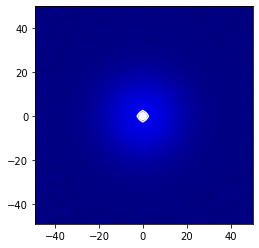

In [393]:
data_fitted = analytical_eq((x, y), *noisy_origins[check_indx],*noisy_preds[check_indx][::-1])

fig, ax = plt.subplots(1, 1)
ax.imshow(normalized_noisy_ims[0].reshape(100, 100), cmap=plt.cm.jet, origin='lower',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(100, 100),10, colors='w')
plt.show()

In [394]:
noisy_analytical_solns = []
for t,n in noisy_labs:
    noisy_analytical_solns.append(analytical_eq((x,y),0,0,n,t))
noisy_analytical_solns = np.array(noisy_analytical_solns)

In [395]:
length = 100
noisy_analytical_solns = np.reshape(noisy_analytical_solns,(test_im_count,length,length))

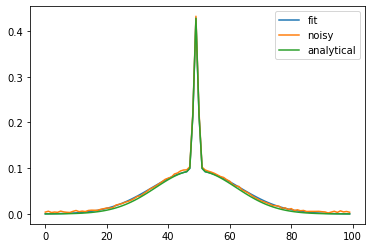

In [397]:
#fit gaussian vs noisy gaussian

row = 50

check = data_fitted.reshape(100,100)
plt.plot(np.arange(len(check[0])),check[row],label = "fit")
plt.plot(np.arange(len(check[0])),normalized_noisy_ims[check_indx,row],label = "noisy")
plt.plot(np.arange(len(check[0])),noisy_analytical_solns[check_indx,row],label = "analytical")
plt.legend()

In [232]:
noisy_labs[check_indx]

array([  139.43210503, 36038.08380333])

In [233]:
noisy_preds[check_indx]

array([  178.59729931, 30877.22892256])

In [234]:
noisy_fit_T_rmse = mean_squared_error(noisy_preds[:,0],noisy_labs[:,0],squared = False)

In [235]:
noisy_fit_T_rmse

56.99156515921587

In [236]:
noisy_fit_N_rmse = mean_squared_error(noisy_preds[:,1],noisy_labs[:,1],squared = False)

In [237]:
noisy_fit_N_rmse

3361.3204227242472